# Linear Rergession Model for Predicting Fork Numbers of Repositories
Yunfan Yang - SENG 550 Fall 2022

## Dependency Preparation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [4]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 50 kB/s 
     |████████████████████████████████| 199 kB 69.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=9622f72869eb66ff5c2f9247033423addbb23a85419c35438040d42ada938d2f
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [5]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [6]:
!wget https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz

--2022-12-16 05:15:26--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299350810 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.1-bin-hadoop3.tgz.1’

spark-3.3.1-bin-had 100%[===================>] 285.48M  49.8MB/s    in 5.6s    

2022-12-16 05:15:32 (50.7 MB/s) - ‘spark-3.3.1-bin-hadoop3.tgz.1’ saved [299350810/299350810]



In [7]:
!tar -xvf spark-3.3.1-bin-hadoop3.tgz

spark-3.3.1-bin-hadoop3/
spark-3.3.1-bin-hadoop3/LICENSE
spark-3.3.1-bin-hadoop3/NOTICE
spark-3.3.1-bin-hadoop3/R/
spark-3.3.1-bin-hadoop3/R/lib/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.1-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/hsearch.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/links.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/nsInfo.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/package.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/vignette.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/NAMESPACE
spark-3.3.1-bin-hadoop3/R/lib/SparkR/R/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/R/SparkR
spark-3.3.1-bin-hadoop3/R/lib/SparkR/R/SparkR.rdb
spark-3.3.1-bin-hadoop3/R/lib/SparkR/R/SparkR.rdx
spark-3.3.1-bin-hadoop3/R/lib/SparkR/doc/
spark-3.3.1-bin-hadoop3/R/lib/Spar

In [8]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
!ls

DataFile.csv   spark-3.3.1-bin-hadoop3	    spark-3.3.1-bin-hadoop3.tgz.1
project.ipynb  spark-3.3.1-bin-hadoop3.tgz


## Initialize Spark

In [10]:
import findspark
findspark.init()

In [11]:
findspark.find()

'/usr/local/lib/python3.8/dist-packages/pyspark'

In [12]:
import pyspark
sc = pyspark.SparkContext(appName="Project")


In [13]:
sc

<SparkContext master=local[*] appName=Project>

In [14]:
fileName1 = "/content/drive/My Drive/Colab Notebooks/DataFile.csv"
fileName1


'/content/drive/My Drive/Colab Notebooks/DataFile.csv'

### Testing Read Dataset


In [15]:
from pyspark.sql import SparkSession


spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

rdd = sc.textFile(fileName1)

df = spark.read \
  .option("header","True") \
  .option("inferSchema","True") \
  .option("sep",",") \
  .csv(rdd)

In [16]:
df.show()

+--------------------+------------------------+---------------------+---------------------+----------------------+----------------+---------------+-------------------+--------------------+---------------+------------------+--------------------+----------------+----------------------+-------------------+--------------------+-------------------+-----------------------+---------------------------+------------------------+----------------------------+---------------------+----------------------+---------------------+------------------------+-------------------------+---------------------+----------------------+---------------+------+------------+------------+------------+-----------+---------------------+----------------+-------------------+--------------+-------------------------------+-----------------------------------+--------------------------------------------+-----------------------------------+-----------------------------------------+---------------------------------------+-------

In [17]:
df.count()

59345

## Read and Pre-process Dataset

In [18]:
from pyspark.sql.functions import when, lit, col, expr, hash
from pyspark.sql.types import FloatType


# Read dataset from CSV file
df = spark.read \
  .option("header","True") \
  .option("inferSchema","True") \
  .option("sep",",") \
  .csv(fileName1)

# Drop null and remove duplicate repository entries
df = df.dropDuplicates(["repository_url"])
df = df.na.drop(subset=["repository_url"])

# Selected only necessary columns
df = df.select("repository_has_downloads", "repository_has_issues", 
               "repository_description", "repository_forks", "repository_fork", 
               "repository_has_wiki", "repository_homepage", "repository_size", 
               "repository_private", "repository_open_issues", 
               "repository_watchers", "repository_language")

# Process column values
df = df.withColumn("repository_size", when(df.repository_size.isNull(), 0).otherwise(df.repository_size)) \
       .withColumn("repository_forks", when(df.repository_forks.isNull(), 0).otherwise(df.repository_forks)) \
       .withColumn("repository_open_issues", when(df.repository_open_issues.isNull() ,0).otherwise(df.repository_open_issues)) \
       .withColumn("repository_watchers", when(df.repository_watchers.isNull(), 0).otherwise(df.repository_watchers)) \
       .fillna(0) \
       \
       .withColumn("repository_forks", col("repository_forks").cast(FloatType())) \
       .withColumn("repository_size", col("repository_size").cast(FloatType())) \
       .withColumn("repository_open_issues", col("repository_open_issues").cast(FloatType())) \
       .withColumn("repository_watchers", col("repository_watchers").cast(FloatType())) \
       \
       .withColumn("repository_description", when(df.repository_description == "TRUE", 1.0).otherwise(0.0)) \
       .withColumnRenamed("repository_description", "repository_has_description") \
       \
       .withColumn("repository_fork", when(df.repository_fork == "TRUE", 1.0).otherwise(0.0)) \
       .withColumnRenamed("repository_fork", "repository_is_fork") \
       \
       .withColumn("repository_has_wiki", when(df.repository_has_wiki == "TRUE", 1.0).otherwise(0.0)) \
       \
       .withColumn("repository_homepage", when(df.repository_homepage == "TRUE", 1.0).otherwise(0.0)) \
       .withColumnRenamed("repository_homepage", "repository_has_homepage") \
       \
       .withColumn("repository_private", when(df.repository_private == "TRUE", 1.0).otherwise(0.0)) \
       .withColumnRenamed("repository_private", "repository_is_private") \
       \
       .withColumn("repository_has_downloads", when(df.repository_has_downloads == True, 1.0).otherwise(0.0)) \
       \
       .withColumn("repository_has_issues", when(df.repository_has_issues == True, 1.0).otherwise(0.0)) \
       \
       .withColumn("repository_has_downloads", col("repository_has_downloads").cast(FloatType())) \
       .withColumn("repository_has_issues", col("repository_has_issues").cast(FloatType())) \
       .withColumn("repository_has_description", col("repository_has_description").cast(FloatType())) \
       .withColumn("repository_is_fork", col("repository_is_fork").cast(FloatType())) \
       .withColumn("repository_has_wiki", col("repository_has_wiki").cast(FloatType())) \
       .withColumn("repository_has_homepage", col("repository_has_homepage").cast(FloatType())) \
       .withColumn("repository_is_private", col("repository_is_private").cast(FloatType())) \

# Fill null value with 0s
df = df.fillna(0)

In [19]:
df.printSchema()

root
 |-- repository_has_downloads: float (nullable = false)
 |-- repository_has_issues: float (nullable = false)
 |-- repository_has_description: float (nullable = false)
 |-- repository_forks: float (nullable = false)
 |-- repository_is_fork: float (nullable = false)
 |-- repository_has_wiki: float (nullable = false)
 |-- repository_has_homepage: float (nullable = false)
 |-- repository_size: float (nullable = false)
 |-- repository_is_private: float (nullable = false)
 |-- repository_open_issues: float (nullable = false)
 |-- repository_watchers: float (nullable = false)
 |-- repository_language: string (nullable = true)



In [20]:
df.count()

17372

In [21]:
df.show()

+------------------------+---------------------+--------------------------+----------------+------------------+-------------------+-----------------------+---------------+---------------------+----------------------+-------------------+-------------------+
|repository_has_downloads|repository_has_issues|repository_has_description|repository_forks|repository_is_fork|repository_has_wiki|repository_has_homepage|repository_size|repository_is_private|repository_open_issues|repository_watchers|repository_language|
+------------------------+---------------------+--------------------------+----------------+------------------+-------------------+-----------------------+---------------+---------------------+----------------------+-------------------+-------------------+
|                     1.0|                  1.0|                       0.0|             6.0|               0.0|                1.0|                    0.0|          112.0|                  0.0|                   0.0|             

## Convert Categorical Attribute to Numerical

Using `StringIndexer`, we can convert language labels into numerical numbers for feature assembling.

In [22]:
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer

label_indexer = StringIndexer(inputCol='repository_language', outputCol='repository_language_indexed').setHandleInvalid("keep")
label_indexer_model = label_indexer.fit(df)
indexed_df = label_indexer_model.transform(df)

In [23]:
indexed_df.select("repository_language", "repository_language_indexed").show()

+-------------------+---------------------------+
|repository_language|repository_language_indexed|
+-------------------+---------------------------+
|               Ruby|                        1.0|
|               null|                       82.0|
|                C++|                        6.0|
|         Emacs Lisp|                       13.0|
|               null|                       82.0|
|               null|                       82.0|
|               null|                       82.0|
|                C++|                        6.0|
|                C++|                        6.0|
|                C++|                        6.0|
|             Python|                        3.0|
|                C++|                        6.0|
|                 C#|                        8.0|
|               Ruby|                        1.0|
|               Ruby|                        1.0|
|               VimL|                       10.0|
|                PHP|                        4.0|


In [100]:
indexed_df.printSchema()

root
 |-- repository_has_downloads: float (nullable = false)
 |-- repository_has_issues: float (nullable = false)
 |-- repository_has_description: float (nullable = false)
 |-- repository_forks: float (nullable = false)
 |-- repository_is_fork: float (nullable = false)
 |-- repository_has_wiki: float (nullable = false)
 |-- repository_has_homepage: float (nullable = false)
 |-- repository_size: float (nullable = false)
 |-- repository_is_private: float (nullable = false)
 |-- repository_open_issues: float (nullable = false)
 |-- repository_watchers: float (nullable = false)
 |-- repository_language: string (nullable = true)
 |-- repository_language_indexed: double (nullable = false)



In [101]:
indexed_df = df.fillna(0)

## Feature Assembling

Using `VectorAssembler` to assemble all eleven features.

In [28]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler() \
        .setInputCols(["repository_has_downloads", "repository_has_issues", 
                       "repository_has_description", # "repository_forks", 
                       "repository_is_fork", "repository_has_wiki", 
                       "repository_has_homepage", "repository_size", 
                       "repository_is_private", "repository_open_issues", 
                       "repository_watchers", "repository_language_indexed"]) \
        .setOutputCol("features") \
        .setHandleInvalid("keep")

assembled_df = assembler.transform(indexed_df)
assembled_df = assembled_df.withColumn("repository_language_indexed", col("repository_language_indexed").cast(FloatType()))

In [29]:
assembled_df.printSchema()

root
 |-- repository_has_downloads: float (nullable = false)
 |-- repository_has_issues: float (nullable = false)
 |-- repository_has_description: float (nullable = false)
 |-- repository_forks: float (nullable = false)
 |-- repository_is_fork: float (nullable = false)
 |-- repository_has_wiki: float (nullable = false)
 |-- repository_has_homepage: float (nullable = false)
 |-- repository_size: float (nullable = false)
 |-- repository_is_private: float (nullable = false)
 |-- repository_open_issues: float (nullable = false)
 |-- repository_watchers: float (nullable = false)
 |-- repository_language: string (nullable = true)
 |-- repository_language_indexed: float (nullable = false)
 |-- features: vector (nullable = true)



## Split Dataset

Into training and testing set.

In [30]:
weights = [.8, .2] # train / test split
seed = 2048

df_training, df_testing = df.randomSplit(weights, seed)

In [31]:
df_training.count()

13950

In [32]:
df_training.describe().show()

+-------+------------------------+---------------------+--------------------------+-----------------+-------------------+-------------------+-----------------------+------------------+---------------------+----------------------+-------------------+-------------------+
|summary|repository_has_downloads|repository_has_issues|repository_has_description| repository_forks| repository_is_fork|repository_has_wiki|repository_has_homepage|   repository_size|repository_is_private|repository_open_issues|repository_watchers|repository_language|
+-------+------------------------+---------------------+--------------------------+-----------------+-------------------+-------------------+-----------------------+------------------+---------------------+----------------------+-------------------+-------------------+
|  count|                   13950|                13950|                     13950|            13950|              13950|              13950|                  13950|             13950|      

In [33]:
df_testing.count()

3422

## Linear Regression Model - First and Second Attempt

In [78]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="repository_forks", maxIter=50, regParam=0.0, elasticNetParam=0.0)

Create a new pipeline

In [81]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[label_indexer, assembler, lr])

Train and test model

In [82]:
model = pipeline.fit(df_training)

In [83]:
predictions = model.transform(df_testing)

In [84]:
predictions.printSchema()

root
 |-- repository_has_downloads: float (nullable = false)
 |-- repository_has_issues: float (nullable = false)
 |-- repository_has_description: float (nullable = false)
 |-- repository_forks: float (nullable = false)
 |-- repository_is_fork: float (nullable = false)
 |-- repository_has_wiki: float (nullable = false)
 |-- repository_has_homepage: float (nullable = false)
 |-- repository_size: float (nullable = false)
 |-- repository_is_private: float (nullable = false)
 |-- repository_open_issues: float (nullable = false)
 |-- repository_watchers: float (nullable = false)
 |-- repository_language: string (nullable = true)
 |-- repository_language_indexed: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [85]:
predictions.select("repository_forks", "prediction", "features").show(truncate=False)

+----------------+-------------------+--------------------------------------------+
|repository_forks|prediction         |features                                    |
+----------------+-------------------+--------------------------------------------+
|0.0             |2.7144588295329743 |(11,[3,6,9,10],[1.0,108.0,1.0,5.0])         |
|0.0             |3.0262981232809683 |(11,[3,6,9,10],[1.0,116.0,1.0,13.0])        |
|0.0             |2.7144515215100684 |(11,[3,6,9,10],[1.0,124.0,1.0,5.0])         |
|0.0             |2.6364816495415733 |(11,[3,6,9,10],[1.0,144.0,1.0,3.0])         |
|0.0             |2.5974976270601893 |(11,[3,6,9,10],[1.0,152.0,1.0,2.0])         |
|0.0             |2.6754437479542386 |(11,[3,6,9,10],[1.0,184.0,1.0,4.0])         |
|0.0             |2.8105752282180303 |(11,[3,6,9,10],[1.0,760.0,2.0,3.0])         |
|0.0             |2.7073627392910025 |(11,[3,6,9,10],[1.0,15644.0,1.0,5.0])       |
|0.0             |-2.955343806275202 |(11,[3,4,6,9],[1.0,1.0,220.0,1.0])    

### Performance Metrics

$R^2 = 0.688479$

In [86]:
from pyspark.ml.evaluation import RegressionEvaluator

r2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="repository_forks", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
r2

0.6884790563541199

$RMSE = 46.2$

In [87]:
rmse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="repository_forks", metricName="rmse")
rmse = rmse_evaluator.evaluate(predictions)
rmse

46.20704893706218

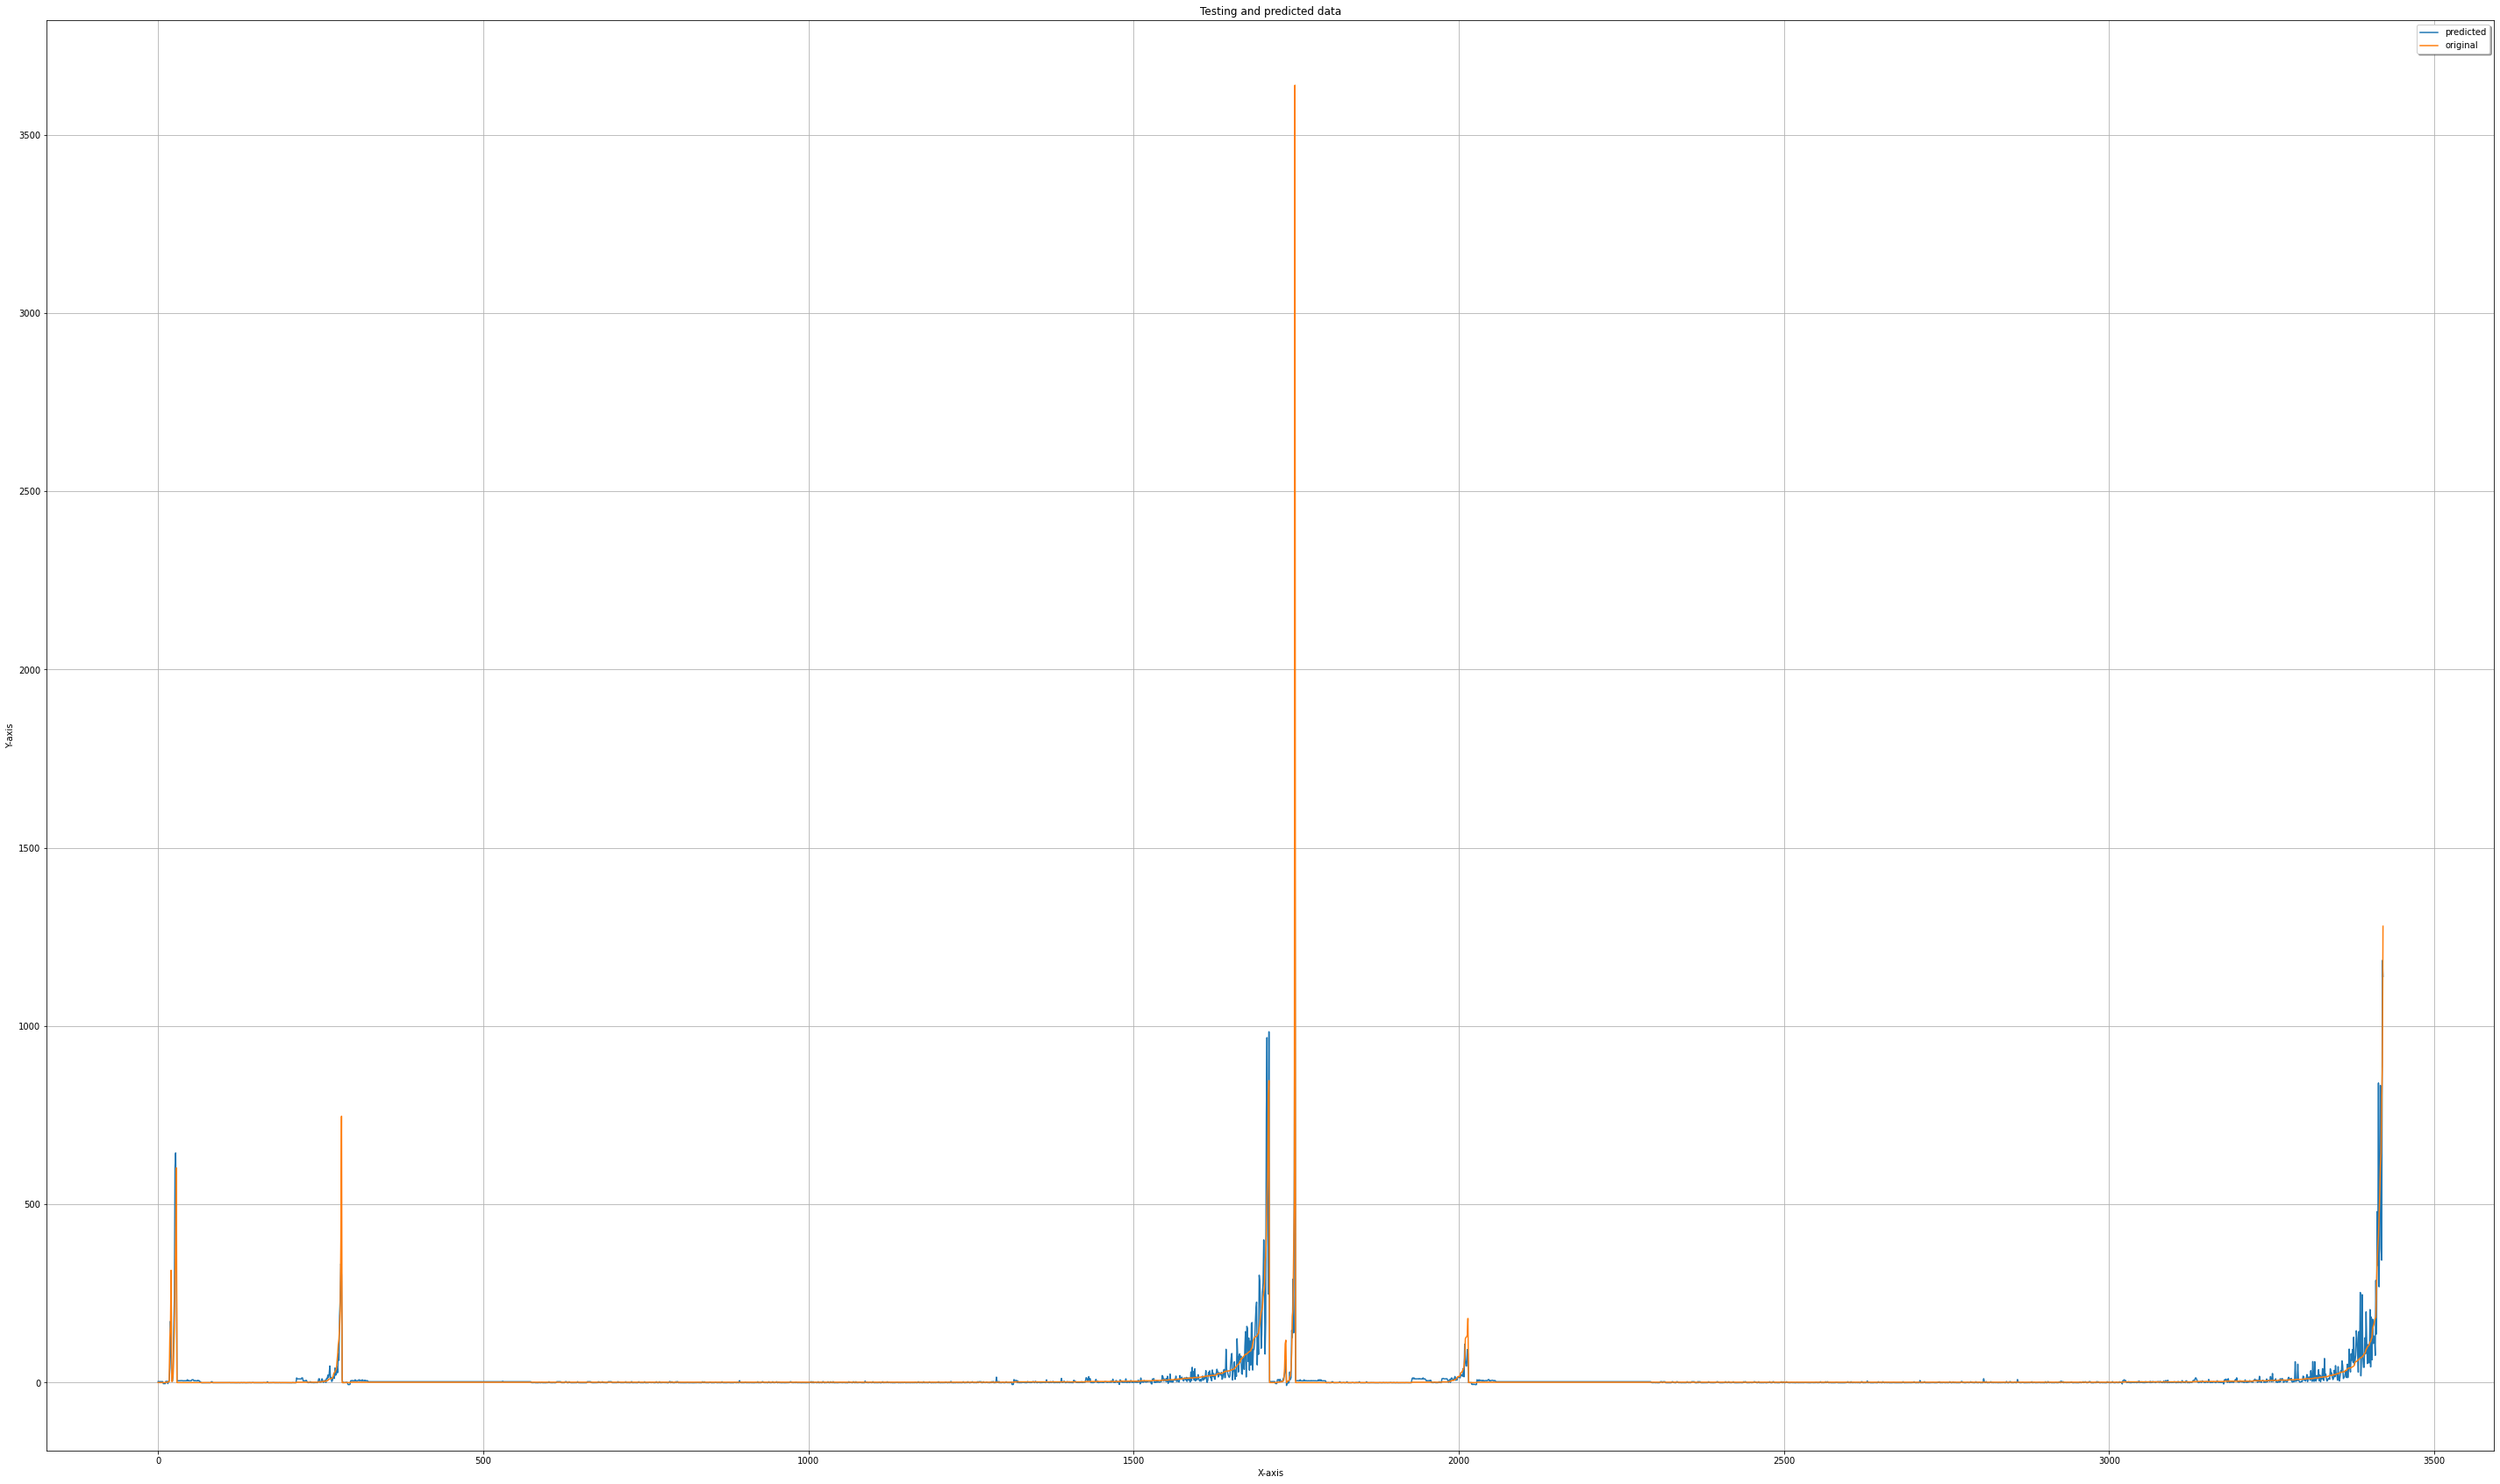

In [88]:
import matplotlib.pyplot as plt

x_ax = range(0, predictions.count())
y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("repository_forks").collect()

plt.rcParams["figure.figsize"] = (50, 30)

plt.plot(x_ax, y_pred, label="predicted")
plt.plot(x_ax, y_orig, label="original")
plt.title("Testing and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

## Linear Regression Model - Third Attempt

The this attemp uses 4th degree polynomial features.

In [102]:
from pyspark.ml.feature import PolynomialExpansion

polynomial_expansion = PolynomialExpansion(degree=4, inputCol="features", outputCol="features_4th")

Create a new pipeline

In [103]:
lr.setFeaturesCol("features_4th")
pipeline = Pipeline(stages=[label_indexer, assembler, polynomial_expansion, lr])

Train and test model

In [104]:
model = pipeline.fit(df_training)
predictions = model.transform(df_testing)

In [105]:
predictions.printSchema()

root
 |-- repository_has_downloads: float (nullable = false)
 |-- repository_has_issues: float (nullable = false)
 |-- repository_has_description: float (nullable = false)
 |-- repository_forks: float (nullable = false)
 |-- repository_is_fork: float (nullable = false)
 |-- repository_has_wiki: float (nullable = false)
 |-- repository_has_homepage: float (nullable = false)
 |-- repository_size: float (nullable = false)
 |-- repository_is_private: float (nullable = false)
 |-- repository_open_issues: float (nullable = false)
 |-- repository_watchers: float (nullable = false)
 |-- repository_language: string (nullable = true)
 |-- repository_language_indexed: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- features_4th: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [106]:
predictions.select("repository_forks", "prediction", "features_4th").show(truncate=False)

+----------------+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Performance Metrics


$R^2 = 0.762387$

In [107]:
from pyspark.ml.evaluation import RegressionEvaluator

r2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="repository_forks", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
r2

0.7623872416814778

$RMSE = 40.355$

In [108]:
rmse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="repository_forks", metricName="rmse")
rmse = rmse_evaluator.evaluate(predictions)
rmse

40.3551983054572

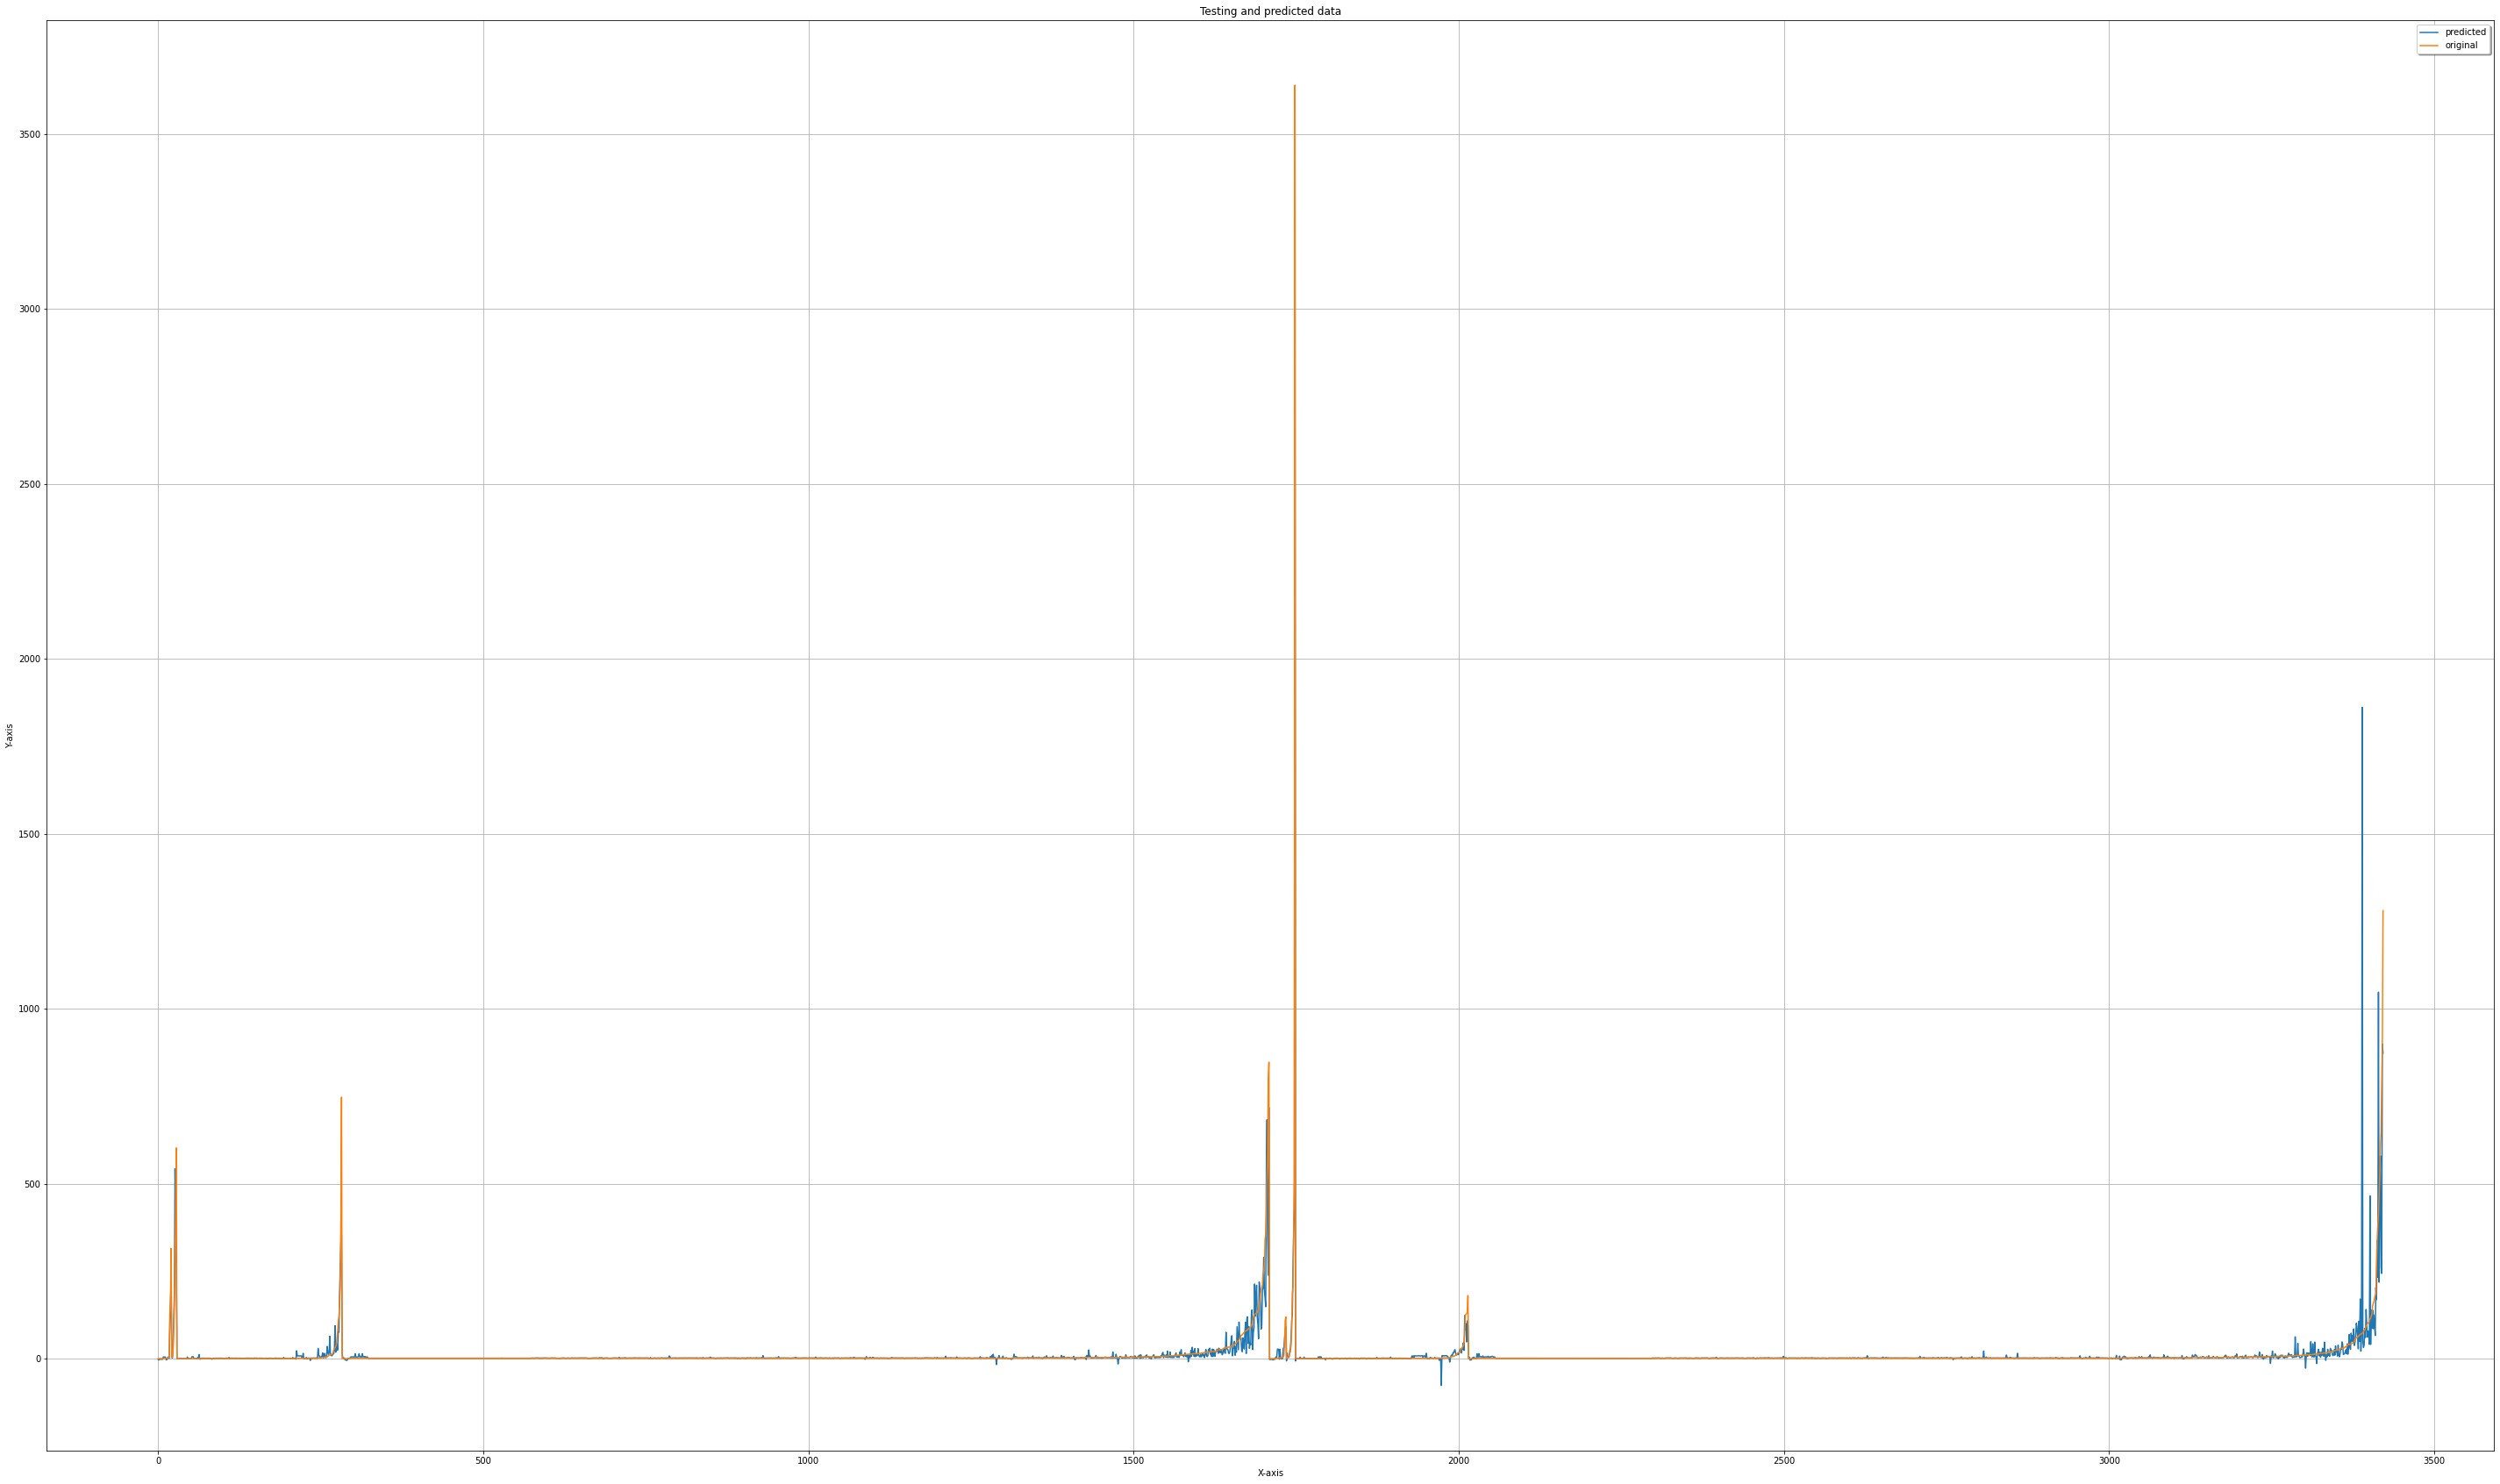

In [109]:
import matplotlib.pyplot as plt

x_ax = range(0, predictions.count())
y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("repository_forks").collect()

plt.rcParams["figure.figsize"] = (50, 30)

plt.plot(x_ax, y_pred, label="predicted")
plt.plot(x_ax, y_orig, label="original")
plt.title("Testing and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

## Linear Regression - Training Set 

In [110]:
predictions = model.transform(df_training)

### Performance Metrics

This is only used for reference and comparison to training set performance metrics.

$R^2 = 0.9535$

In [111]:
from pyspark.ml.evaluation import RegressionEvaluator

r2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="repository_forks", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
r2

0.9535339229634866

$RMSE = 18.478$

In [112]:
rmse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="repository_forks", metricName="rmse")
rmse = rmse_evaluator.evaluate(predictions)
rmse

18.478164476948443